对1872年至2022年国际足球成绩进行分析和预处理

In [73]:
import pandas as pd
import numpy as np 
import re
df =  pd.read_csv("datasets/results.csv")

In [74]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47126 entries, 0 to 47125
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        47126 non-null  object 
 1   home_team   47111 non-null  object 
 2   away_team   47111 non-null  object 
 3   home_score  47075 non-null  float64
 4   away_score  47075 non-null  float64
 5   tournament  47126 non-null  object 
 6   city        47126 non-null  object 
 7   country     47126 non-null  object 
 8   neutral     47126 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.9+ MB


In [76]:
#缺失值查看、
df.isna().sum()

date           0
home_team     15
away_team     15
home_score    51
away_score    51
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [77]:
df = df.drop(df[df['date']=='2022-19-22'].index,axis=0)

In [78]:
#删除缺失值所在的行
df.dropna(inplace=True)
#将日期列的格式转换为日期格式
df["date"] = pd.to_datetime(df["date"])

使用的数据集将是FIFA，从2020年10-1后到2024年欧洲杯杯前的最后一场比赛。这个想法是为了分析欧洲杯准备和分类阶段的比赛情况。

In [79]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
47044,2024-03-26,Tajikistan,Saudi Arabia,1.0,1.0,FIFA World Cup qualification,Dushanbe,Tajikistan,False
47045,2024-03-26,Jordan,Pakistan,7.0,0.0,FIFA World Cup qualification,Amman,Jordan,False
47046,2024-03-26,Bahrain,Nepal,3.0,0.0,FIFA World Cup qualification,Riffa,Bahrain,False
47048,2024-03-26,Bangladesh,Palestine,0.0,1.0,FIFA World Cup qualification,Dhaka,Bangladesh,False
47074,2024-03-26,Finland,Estonia,2.0,1.0,Friendly,Helsinki,Finland,False


In [80]:
#df = df[(df["date"] >= "2020-10-1")].reset_index(drop=True)
df = df[(df["date"] >= "2020-10-1") & (df["date"] <= "2022-11-21")].reset_index(drop=True)

In [81]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
2263,2022-11-20,Austria,Italy,2.0,0.0,Friendly,Vienna,Austria,False
2271,2022-11-20,North Macedonia,Azerbaijan,1.0,3.0,Friendly,Skopje,North Macedonia,False
2282,2022-11-21,England,Iran,6.0,2.0,FIFA World Cup,Al Rayyan,Qatar,True
2281,2022-11-21,Senegal,Netherlands,0.0,2.0,FIFA World Cup,Doha,Qatar,True
2283,2022-11-21,United States,Wales,1.0,1.0,FIFA World Cup,Al Rayyan,Qatar,True


对FIFA世界排名1992-2024年数据进行处理

In [82]:
rank = pd.read_csv("datasets//fifa_ranking-2024-04-04.csv")

In [83]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2020-10-1")].reset_index(drop=True)

In [84]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

两表进行Merge

将日期设置为我们的索引，然后根据国家进行分组，再重新采样每一天的第一条数据作为我们的数据，最后重置索引

In [85]:
#将日期设置为我们的索引，然后根据国家进行分组，再重新采样每一天的第一条数据作为我们的数据，最后重置索引
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

C:\Users\顾宇豪\AppData\Local\Temp\ipykernel_25908\3880538776.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()


In [86]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]],
 left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

In [87]:
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], 
left_on=["date", "away_team"], right_on=["rank_date", "country_full"], 
suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

展示下法国最近的战绩

In [88]:
df_wc_ranked[(df_wc_ranked.home_team == "France") | (df_wc_ranked.away_team == "France")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
922,2021-10-10,Spain,France,1.0,2.0,UEFA Nations League,Milan,Italy,True,1673.68,1680.44,8.0,1.0,1754.31,1761.77,4.0,1.0
1045,2021-11-13,France,Kazakhstan,8.0,0.0,FIFA World Cup qualification,Paris,France,False,1779.24,1754.31,3.0,-1.0,1137.46,1151.18,125.0,5.0
1106,2021-11-16,Finland,France,0.0,2.0,FIFA World Cup qualification,Helsinki,Finland,False,1403.96,1406.92,60.0,5.0,1779.24,1754.31,3.0,-1.0
1411,2022-03-29,France,South Africa,5.0,0.0,Friendly,Villeneuve D'Ascq,Algeria,True,1786.15,1786.15,3.0,0.0,1358.24,1358.24,68.0,0.0
1490,2022-06-03,France,Denmark,1.0,2.0,UEFA Nations League,Paris,France,False,1789.85,1786.15,3.0,0.0,1653.60,1654.54,11.0,2.0
1541,2022-06-06,Croatia,France,1.0,1.0,UEFA Nations League,Split,Croatia,False,1621.11,1620.74,16.0,1.0,1789.85,1786.15,3.0,0.0
1605,2022-06-10,Austria,France,1.0,1.0,UEFA Nations League,Vienna,Austria,False,1500.37,1511.56,34.0,4.0,1789.85,1786.15,3.0,0.0
1659,2022-06-13,France,Croatia,0.0,1.0,UEFA Nations League,Paris,France,False,1789.85,1786.15,3.0,0.0,1621.11,1620.74,16.0,1.0
1739,2022-09-22,France,Austria,2.0,0.0,UEFA Nations League,Paris,France,False,1764.85,1764.85,4.0,0.0,1502.47,1502.47,33.0,0.0
1797,2022-09-25,Denmark,France,2.0,0.0,UEFA Nations League,Copenhagen,Denmark,False,1665.47,1665.47,10.0,0.0,1764.85,1764.85,4.0,0.0


特征工程

    这是的想法是创造更多对足球比赛胜负有影响的特征
    我们认为影响的特征可能是以下几个: 1.球队的历史得分 2.球队历史的进球与失球 3.球队的排名 4.球队排名的上升情况 5.排名所面临的进球和损失 6.比赛的重要性（是否友好）
    因此我们要创建一个功能：判断哪支队赢了，以及他们在比赛中获得了多少分

In [89]:
df = df_wc_ranked
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)
df[["result", "home_team_points", "away_team_points"]] = results

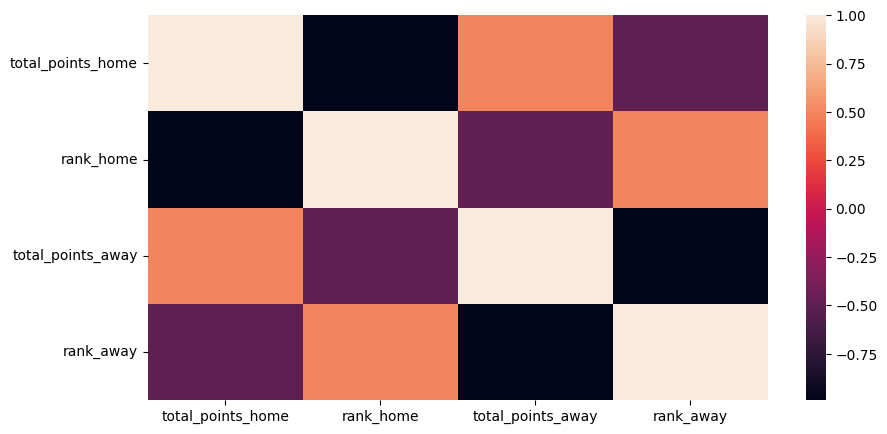

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

In [91]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]  #排名差异
df["sg"] = df["home_score"] - df["away_score"]  #分数差异
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"] #主场队伍进球与排名的关系
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"] #客场队伍进球与排名的关系

为了更好的特征衍生，我们将数据集分为主队和客队的数据集，然后合并一起计算它们过去比赛的各种特征。 之后再将它们分离并合并，构造出一个原始的数据集。 这个过程优化了特征衍生

In [92]:
#先分离数据集
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [93]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [94]:
team_stats = pd.concat([home_team, away_team])

In [95]:
team_stats_raw = team_stats.copy()

得到数据集后，进行第二次特征衍生

In [96]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last10 = past_games.head(10) #取出过去五场比赛
    
    goals = past_games["score"].mean()
    goals_l10 = last10["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l10 = last10["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l10 = last10["rank_suf"].mean()
    
    if len(last10) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l10 = last10["total_points"].values[0] - last10["total_points"].values[-1] 
    else:
        points = 0
        points_l10 = 0
        
    gp = past_games["team_points"].mean()
    gp_l10 = last10["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l10 = last10["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l10, goals_suf, goals_suf_l10, rank, rank_l10, points, points_l10, gp, gp_l10, gp_rank, gp_rank_l10])

In [97]:
stats_cols = ["goals_mean", "goals_mean_l10", "goals_suf_mean", "goals_suf_mean_l10", "rank_mean", "rank_mean_l10", "points_mean", "points_mean_l10", "game_points_mean", "game_points_mean_l10", "game_points_rank_mean", "game_points_rank_mean_l10"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [98]:

home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [99]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [100]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l10', 'home_goals_suf_mean',
       'home_goals_suf_mean_l10', 'home_rank_mean', 'home_rank_mean_l10',
       'home_points_mean', 'home_points_mean_l10', 'home_game_points_mean',
       'home_game_points_mean_l10', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l10', 'away_goals_mean',
       'away_goals_mean_l10', 'away_goals_suf_mean', 'away_goals_suf_mean_l10',
       'away_rank_mean', 'away_rank_mean_l10', 'away_points_mean',
       'away_points_mean_l10', 'away_game_points_mean',
       'away_game_points_mean_l

In [101]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [102]:

full_df = pd.get_dummies(full_df, columns=["is_friendly"])

对特征工程后的数据集进行数据分析


In [103]:

a = ["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l10', 'home_goals_suf_mean', 'home_goals_suf_mean_l10',
       'home_rank_mean', 'home_rank_mean_l10', 'home_points_mean',
       'home_points_mean_l10', 'away_goals_mean', 'away_goals_mean_l10',
       'away_goals_suf_mean', 'away_goals_suf_mean_l10', 'away_rank_mean',
       'away_rank_mean_l10', 'away_points_mean', 'away_points_mean_l10','home_game_points_mean', 'home_game_points_mean_l10',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l10','away_game_points_mean',
       'away_game_points_mean_l10', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l10',
       'is_friendly_0', 'is_friendly_1']
base_df = full_df[a]
base_df.head()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l10,home_game_points_rank_mean,home_game_points_rank_mean_l10,away_game_points_mean,away_game_points_mean_l10,away_game_points_rank_mean,away_game_points_rank_mean_l10,is_friendly_0,is_friendly_1
0,2020-11-06,Ethiopia,Sudan,146.0,128.0,2.0,2.0,2,18.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
1,2020-11-07,Bahrain,Tajikistan,99.0,122.0,1.0,0.0,0,-23.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2,2020-11-11,Albania,Kosovo,69.0,117.0,2.0,1.0,0,-48.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
3,2020-11-11,Belgium,Switzerland,1.0,16.0,2.0,1.0,0,-15.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
4,2020-11-11,Bulgaria,Gibraltar,66.0,195.0,3.0,0.0,0,-129.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [104]:
base_df.isna().sum()

date                                0
home_team                           0
away_team                           0
rank_home                           0
rank_away                           0
home_score                          0
away_score                          0
result                              0
rank_dif                            0
rank_change_home                    0
rank_change_away                    0
home_goals_mean                    88
home_goals_mean_l10                88
home_goals_suf_mean                88
home_goals_suf_mean_l10            88
home_rank_mean                     88
home_rank_mean_l10                 88
home_points_mean                    0
home_points_mean_l10                0
away_goals_mean                   102
away_goals_mean_l10               102
away_goals_suf_mean               102
away_goals_suf_mean_l10           102
away_rank_mean                    102
away_rank_mean_l10                102
away_points_mean                    0
away_points_

In [105]:
base_df_no_fg = base_df.dropna()

特征分析

In [106]:

df = base_df_no_fg
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\顾宇豪\AppData\Local\Temp\ipykernel_25908\290120828.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


In [107]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [108]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

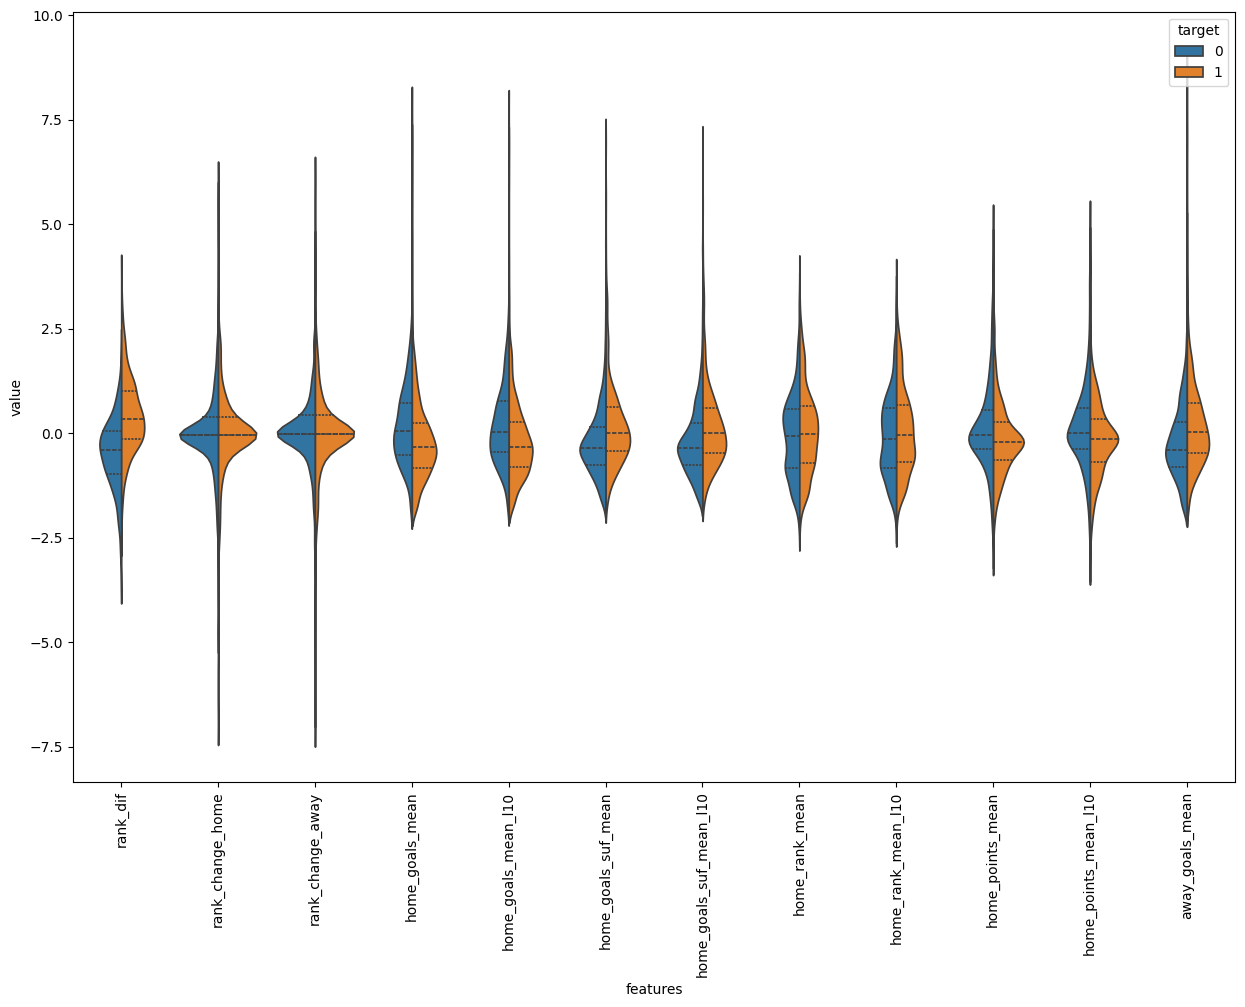

In [109]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

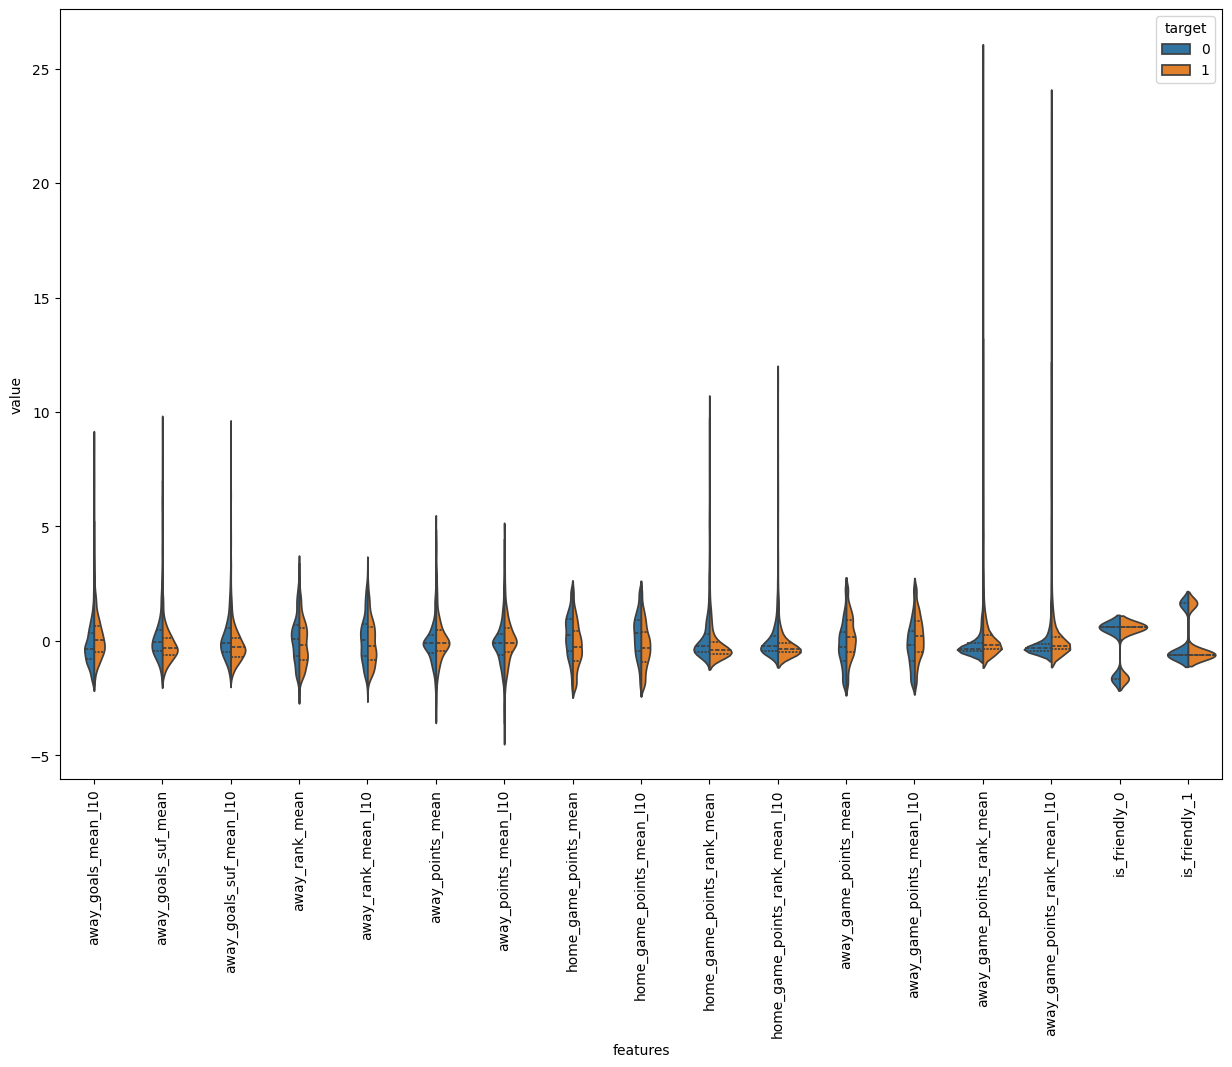

In [110]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

继续构建特征

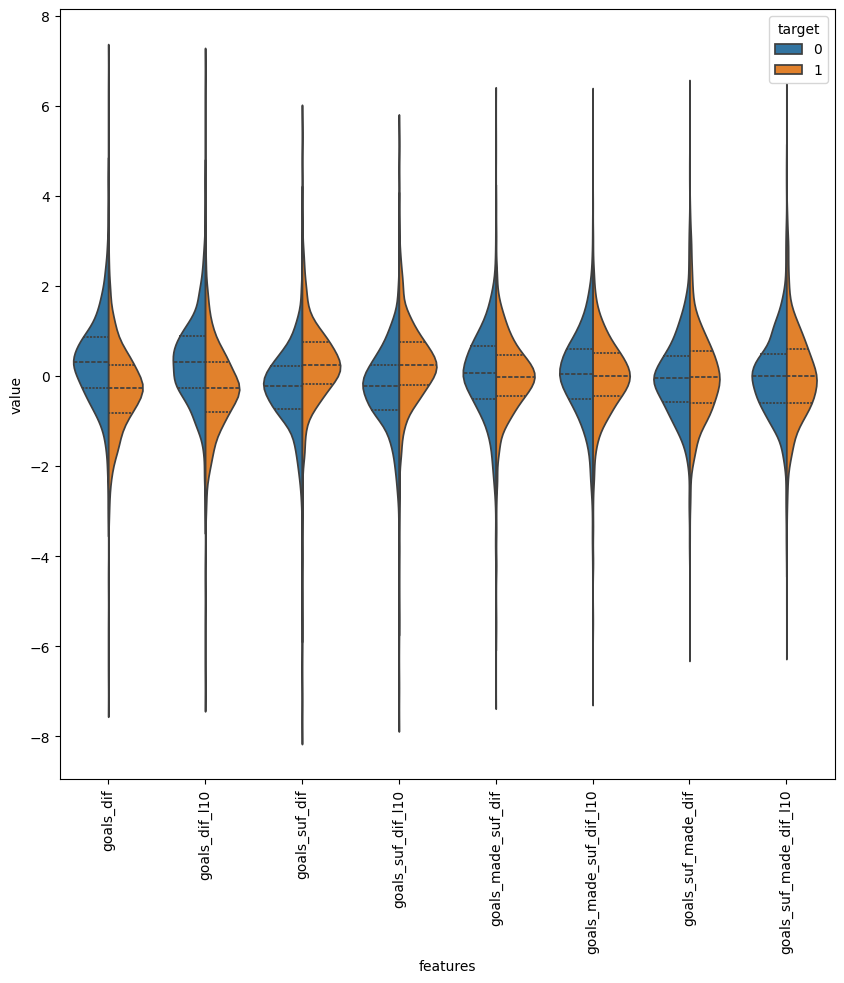

In [111]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l10"] = dif["home_goals_mean_l10"] - dif["away_goals_mean_l10"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l10"] = dif["home_goals_suf_mean_l10"] - dif["away_goals_suf_mean_l10"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l10"] = dif["home_goals_mean_l10"] - dif["away_goals_suf_mean_l10"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l10"] = dif["home_goals_suf_mean_l10"] - dif["away_goals_mean_l10"]

data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

In [112]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l10"] = dif["home_game_points_mean_l10"] - dif["away_game_points_mean_l10"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l10"] = dif["home_game_points_rank_mean_l10"] - dif["away_game_points_rank_mean_l10"]

dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l10"] = dif["home_rank_mean_l10"] - dif["away_rank_mean_l10"]

In [113]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l10"] = (dif["home_goals_mean_l10"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l10"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l10"] = (dif["home_goals_suf_mean_l10"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l10"] / dif["away_rank_mean"])

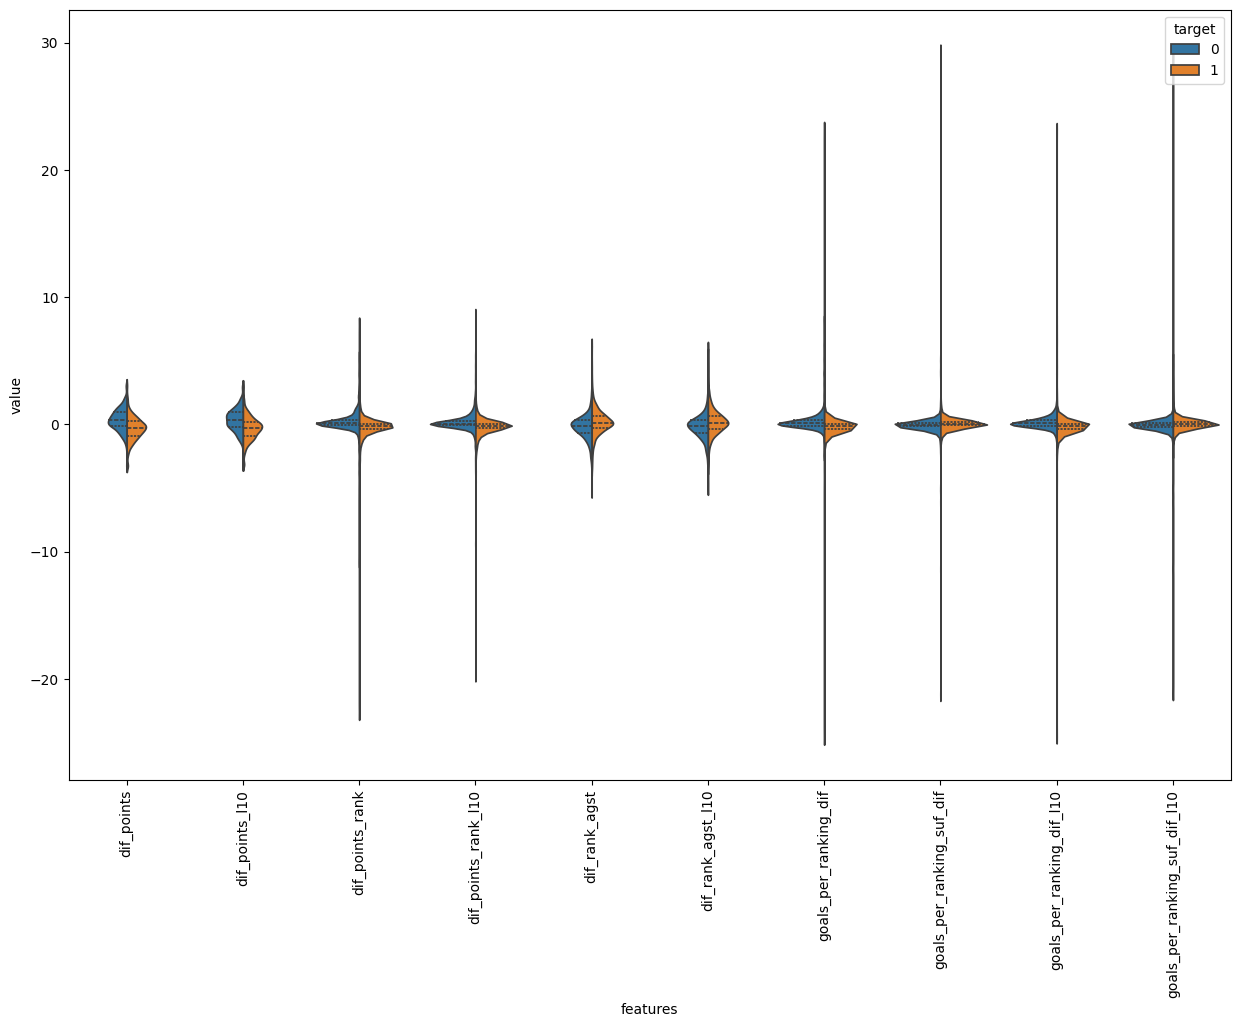

In [114]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

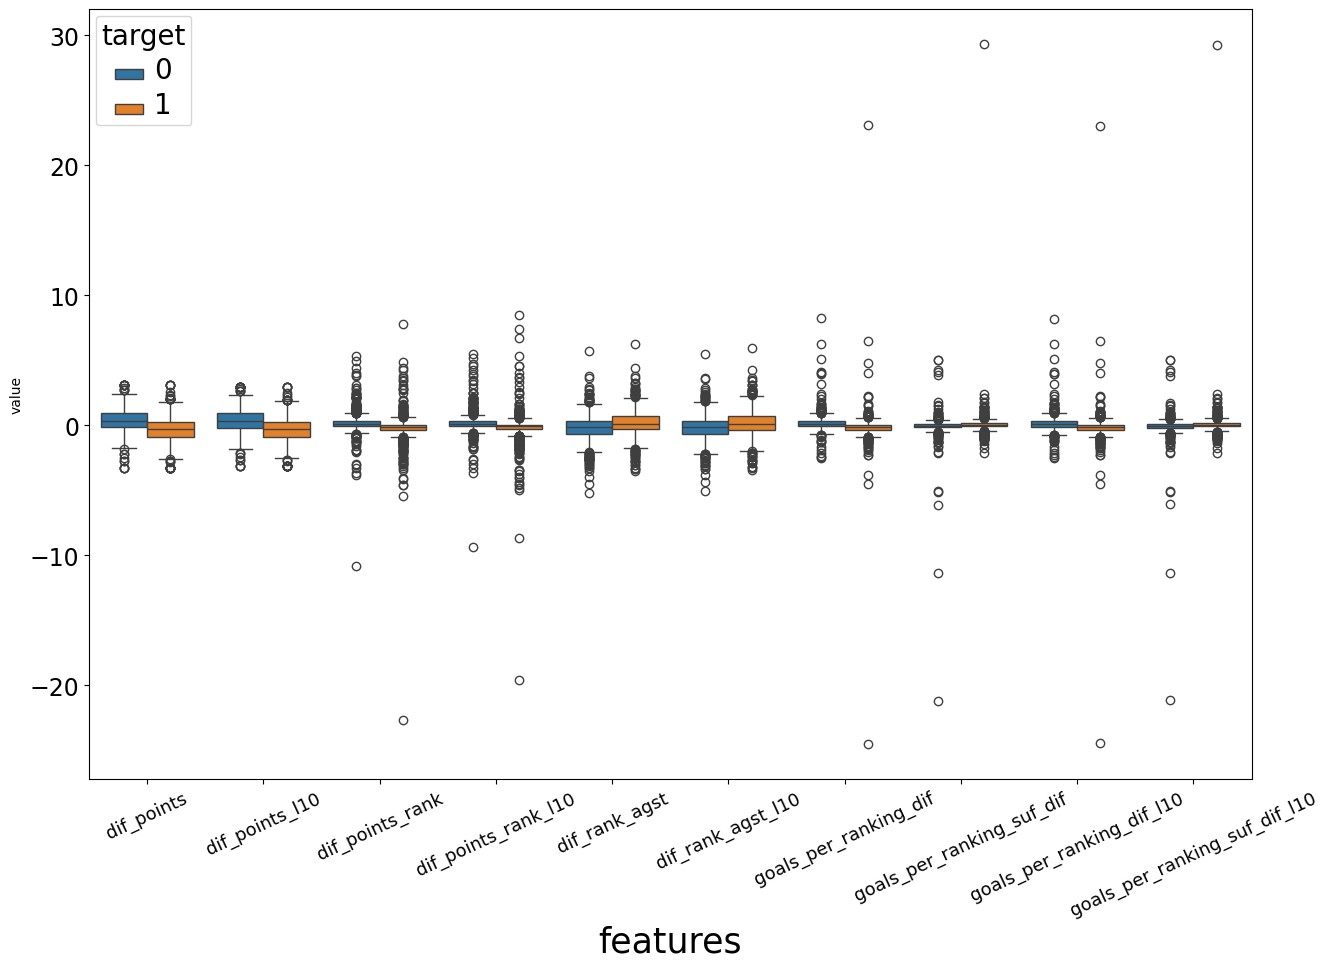

In [115]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=25, fontsize=13)
plt.yticks(fontsize=17)
plt.xlabel("features", fontsize=25)
# 获取图例
legend = plt.legend(title="target")
# 设置hue标签标题的字体大小
legend.get_title().set_fontsize('20')
legend.get_texts()[0].set_fontsize('20') 
legend.get_texts()[1].set_fontsize('20') 
plt.show()

    ·从中可以看出，Difference of points (所有比赛和最近5场比赛), difference of points by ranking faced (所有比赛和最近5场比赛) 和 difference of rank faced (所有比赛和最近5场比赛)是很好的特征。

    另外，一些衍生出来的特征具有非常相似的分布，对于这些特征，我们将使用散点图进行分析。

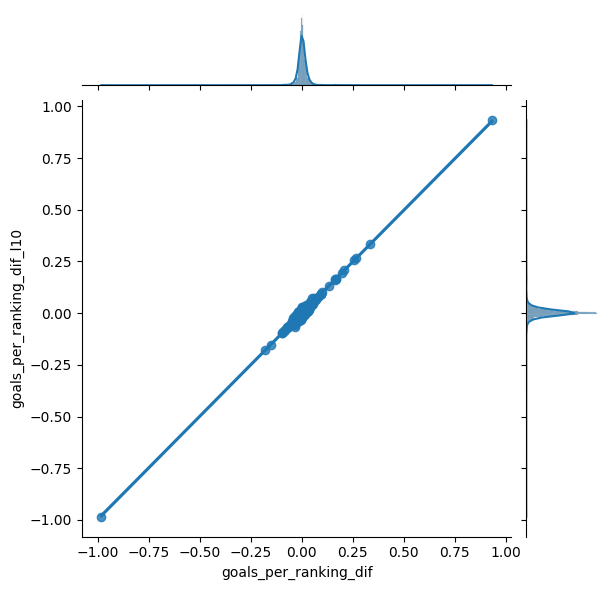

In [116]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l10', kind="reg")
plt.show()

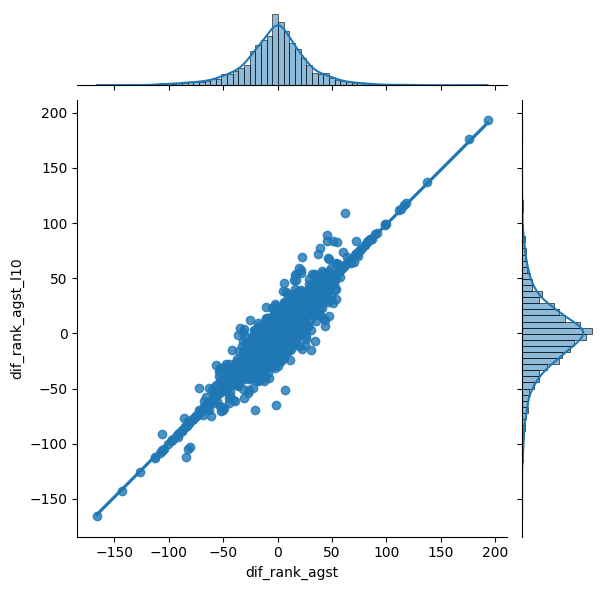

In [117]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l10', kind="reg")
plt.show()

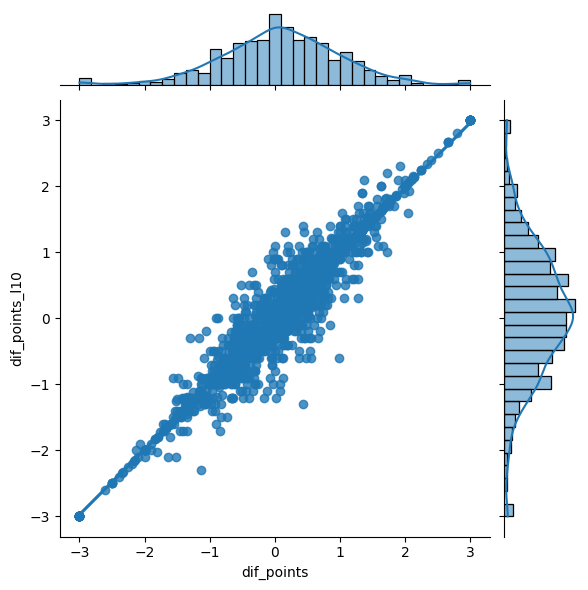

In [118]:

sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l10', kind="reg")
plt.show()

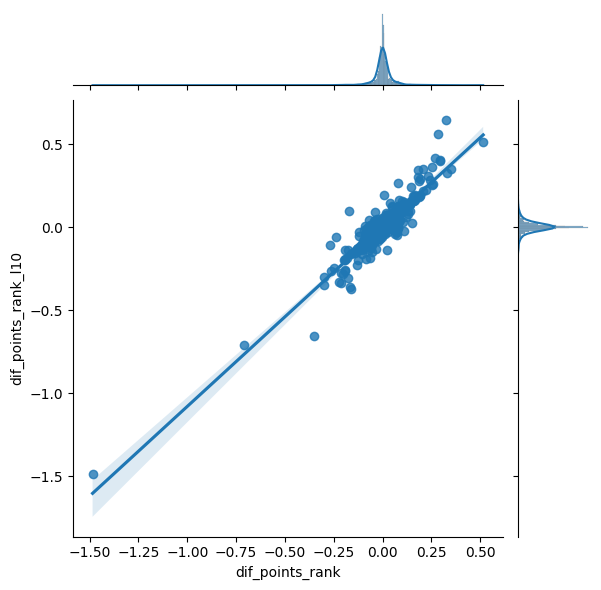

In [119]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l10', kind="reg")
plt.show()

因为排名差异，积分差异，排名平均积分差异这两个版本（所有数据、最近5场比赛）并不那么相似，因此我们决定两个版本都使用。因此，我们特征筛选最后的结果是：

rank_dif

goals_dif

goals_dif_l10

goals_suf_dif

goals_suf_dif_l10

dif_rank_agst

dif_rank_agst_l10

goals_per_ranking_dif

dif_points_rank

dif_points_rank_l10

is_friendly

创建各国家的特征数据库

In [120]:

def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l10", "away_rank_mean_l10", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l10", "away_goals_mean_l10", "home_goals_suf_mean_l10", "away_goals_suf_mean_l10", "home_game_points_rank_mean", "home_game_points_rank_mean_l10", "away_game_points_rank_mean", "away_game_points_rank_mean_l10","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l10"] = base["home_goals_mean_l10"] - base["away_goals_mean_l10"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l10"] = base["home_goals_suf_mean_l10"] - base["away_goals_suf_mean_l10"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l10"] = base["home_rank_mean_l10"] - base["away_rank_mean_l10"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l10"] = base["home_game_points_rank_mean_l10"] - base["away_game_points_rank_mean_l10"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l10", "goals_suf_dif", "goals_suf_dif_l10", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l10", "dif_points_rank", "dif_points_rank_l10", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [121]:
model_db = create_db(df)
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l10,goals_suf_dif,goals_suf_dif_l10,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l10,dif_points_rank,dif_points_rank_l10,is_friendly_0,is_friendly_1
58,Portugal,France,1,3.0,7.000000,7.0,-2.000000,-2.0,0.048276,90.000000,90.0,0.020690,0.020690,True,False
59,Sweden,Croatia,0,10.0,-3.000000,-3.0,-1.000000,-1.0,-0.090909,-20.000000,-20.0,-0.030303,-0.030303,True,False
60,Germany,Ukraine,0,-9.0,1.000000,1.0,-2.000000,-2.0,0.022222,27.000000,27.0,0.066667,0.066667,True,False
61,Switzerland,Spain,1,10.0,0.000000,0.0,1.000000,1.0,0.933333,-14.000000,-14.0,-0.066667,-0.066667,True,False
62,Azerbaijan,Montenegro,1,50.0,0.000000,0.0,0.000000,0.0,0.000000,-57.000000,-57.0,0.007726,0.007726,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,Uzbekistan,Russia,1,44.0,0.578947,0.6,-0.210526,0.2,-0.000860,34.473684,40.5,-0.009100,-0.010250,False,True
1945,Qatar,Ecuador,1,6.0,0.278818,0.5,0.171429,0.1,-0.017170,37.987192,27.7,-0.068743,-0.082334,True,False
1946,Senegal,Netherlands,1,10.0,-1.067130,-1.0,-0.244213,-0.2,-0.034214,47.315972,56.4,-0.161233,-0.374006,True,False
1947,England,Iran,0,-15.0,0.288998,1.1,0.144499,0.5,0.019882,-25.673235,-15.7,0.045811,0.018430,True,False


建立预测模型

通过上面步骤，我们已经得到了一个具有预测能力的数据集，我们可以开始我们的建模了
在本次任务中，我们将建立两个模型（RFC、GBDT）。最终选择召回率最佳的模型作为我们的预测模型。

In [122]:

X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [123]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

GBDT算法

In [53]:

gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.05,0.01, 0.1, 0.5],
            "min_samples_split":[5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10,20],
            "max_features":["sqrt"],
            "n_estimators":[100,150,200,225,250,300]
         } 

gb_cv = GridSearchCV(gb, params,cv = 3, verbose = True)

gb_cv.fit(X_train.values, np.ravel(y_train))

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             param_grid={'learning_rate': [0.05, 0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10, 20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 200, 225, 250, 300]},
             verbose=True)

In [54]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=10,
                           random_state=5)

随机森林算法

In [55]:
params_rf = {"max_depth": [10,20,35,50],
                "min_samples_split": [5,10,20],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [100,150,250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 5, verbose = True)

rf_cv.fit(X_train.values, np.ravel(y_train))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 20, 35, 50],
                         'max_features': ['sqrt'], 'max_leaf_nodes': [175],
                         'min_samples_leaf': [5],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 150, 250]},
             verbose=True)

In [56]:
rf = rf_cv.best_estimator_
rf

RandomForestClassifier(max_depth=10, max_leaf_nodes=175, min_samples_leaf=5,
                       min_samples_split=20, n_estimators=250, random_state=1)

泊松分布

In [126]:
from sklearn.datasets import make_classification
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

param_pos = {
    'alpha': [0.05, 0.1, 1.0, 10.0],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'max_iter': [50, 100, 200, 300, 500]
}

# 创建PoissonRegressor模型
poisson_reg = PoissonRegressor()

# 使用GridSearchCV寻找最佳参数
pos_cv = GridSearchCV(estimator=poisson_reg, param_grid=param_pos, cv=3)
pos_cv.fit(X_train.values, np.ravel(y_train))

pos = pos_cv.best_params_
# 输出最佳参数
print("Best parameters found: ", pos)


c:\Users\顾宇豪\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\顾宇豪\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\顾宇豪\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

Best parameters found:  {'alpha': 0.1, 'max_iter': 100, 'tol': 0.001}


c:\Users\顾宇豪\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


SVM

In [128]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 定义SVM分类器模型
svm = SVC()

# 定义参数网格
param_svm = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf',  'poly']
}

# 使用GridSearchCV寻找最佳参数
svm_cv = GridSearchCV(estimator=svm, param_grid=param_svm, cv=3)
svm_cv.fit(X_train.values, np.ravel(y_train))

# 输出最佳参数
print("Best parameters found: ", svm_cv.best_params_)

XGBoost分类器

In [ ]:
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 定义XGBoost分类器模型
xgb = XGBClassifier()

# 定义参数网格
param_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9]
}

# 使用GridSearchCV寻找最佳参数
xgb_cv = GridSearchCV(estimator=xgb, param_grid=param_xgb, cv=3)
xgb_cv.fit(X, y)
xgb = xgb_cv.best_params_
# 输出最佳参数
print("Best parameters found: ", xgb)

模型对比

在这里，我们使用混淆矩阵以及ROC曲线进行模型对比

In [57]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [58]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

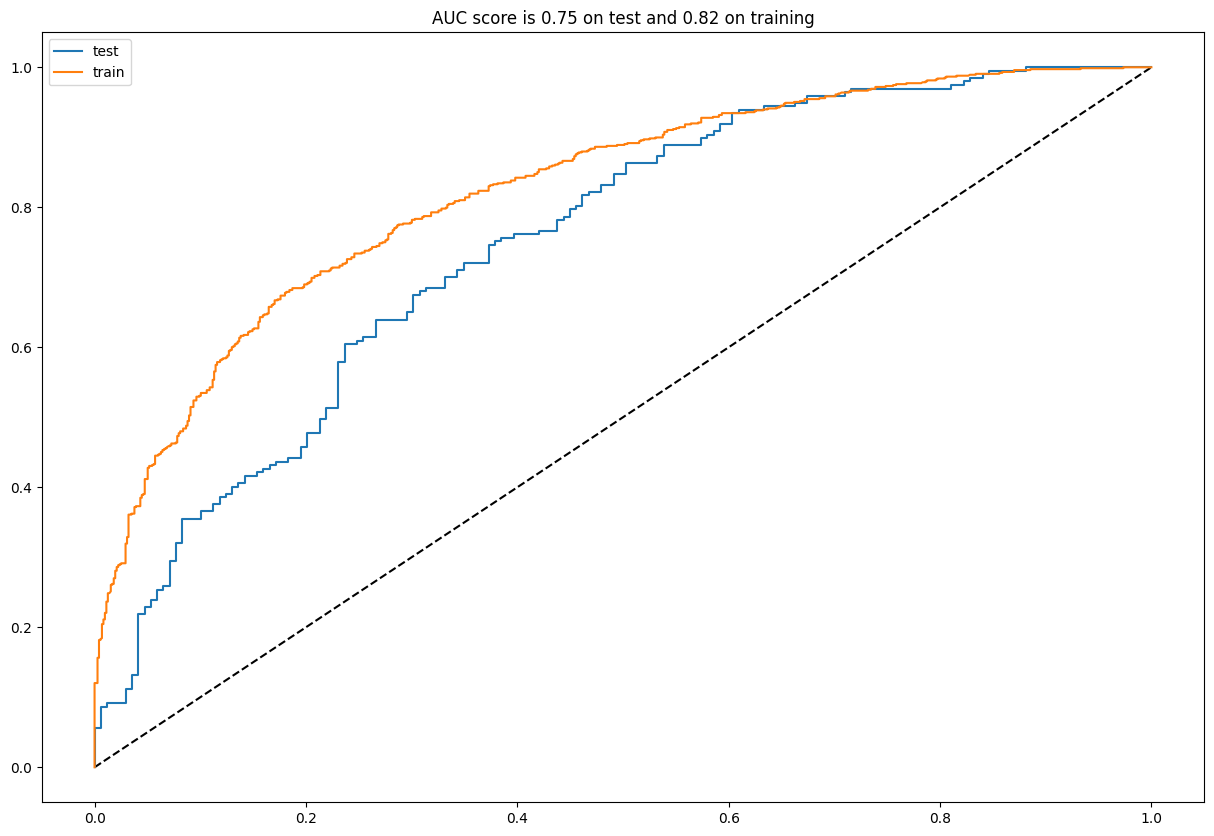

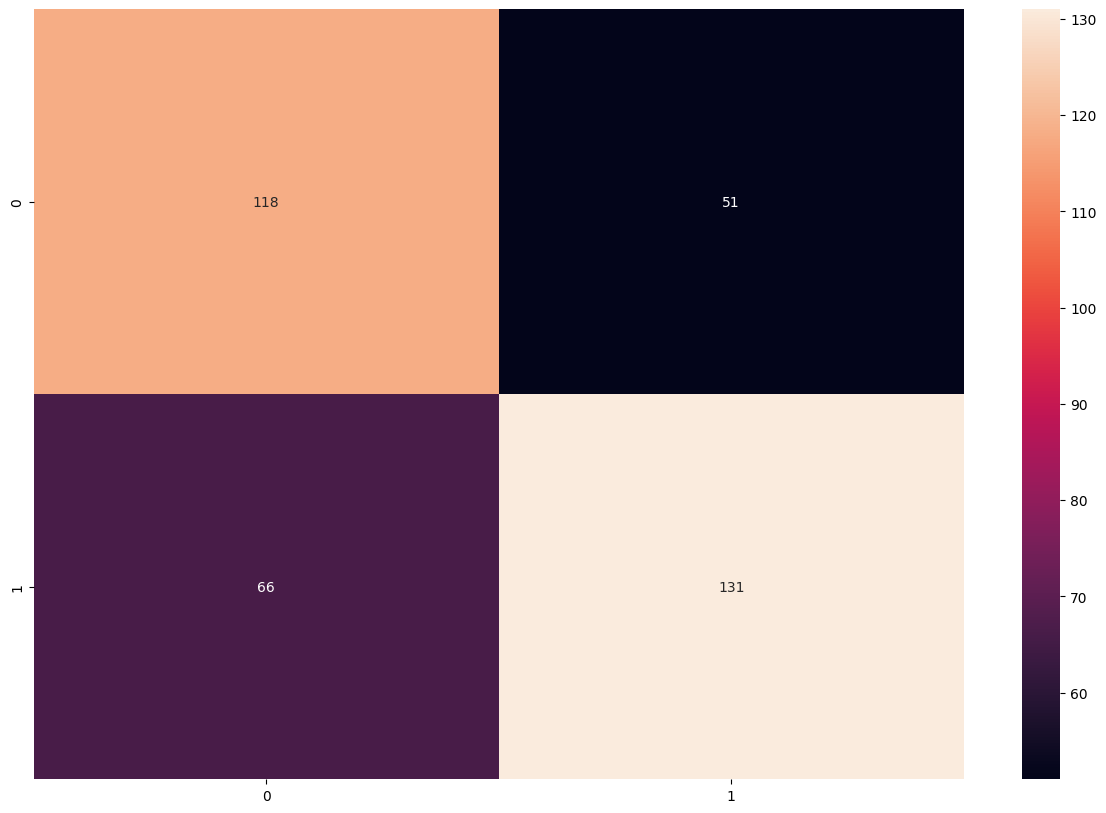

In [59]:

analyze(gb)

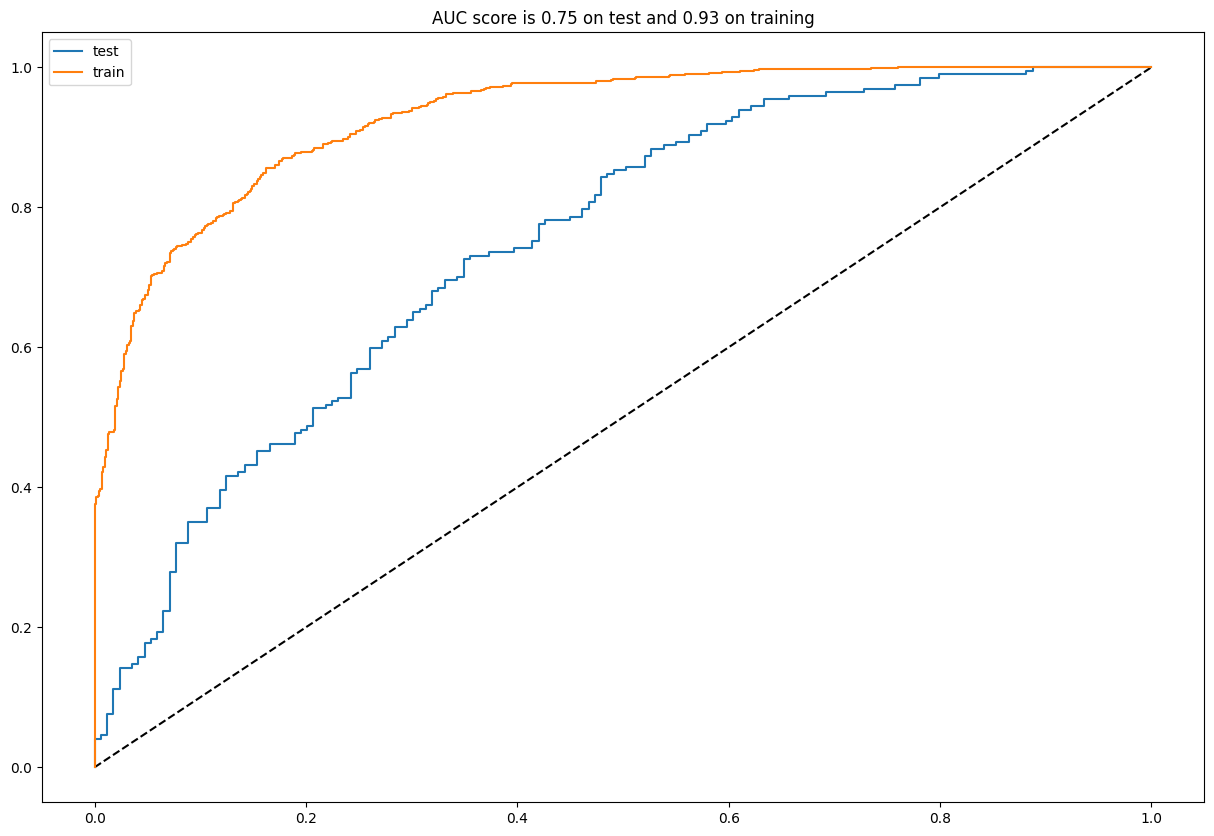

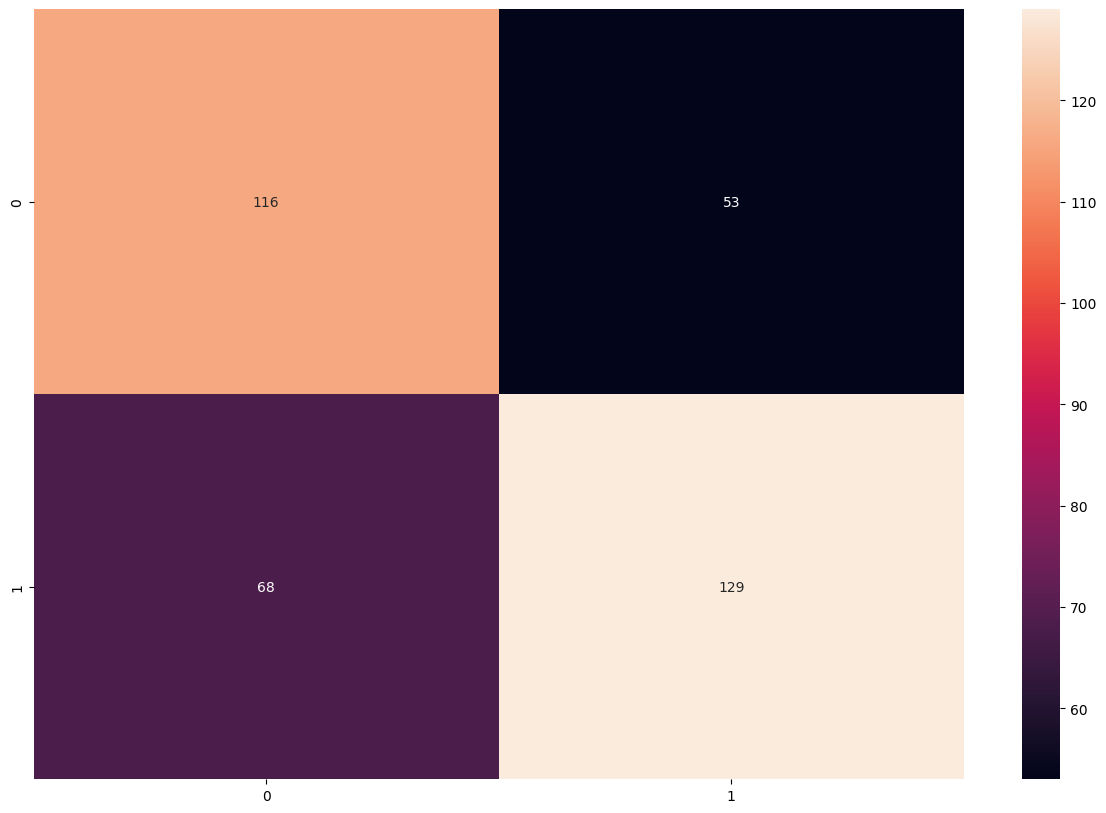

In [60]:
analyze(rf)

通过分析发现，随机森林模型或许稍微好一点，但似乎泛化能力不行。因此我们将使用GBDT模型

In [61]:

from operator import itemgetter
#dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")
# dfs = pd.read_html('https://en.wikipedia.org/wiki/UEFA_Euro_2024#Teams')

欧洲杯模拟

第一件事是创建UEFA欧洲杯游戏

要做到这一点，我们得先在维基百科中获得球队和小组赛阶段的比赛

In [62]:
from collections.abc import Iterable
# for i in range(len(dfs)):
#     df = dfs[i]
#     cols = list(df.columns.values)

#     if isinstance(cols[0], Iterable):
#         if any("Country', 'Fourth official', 'Reserve assistant referee" in c for c in cols):
#             start_pos = i+1

#         if any("Match 14" in c for c in cols):
#             end_pos = i+1

matches = []
# #groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
groups = ["A", "B", "C", "D", "E", "F"]
# group_count = 0 
# print(start_pos)
# print(end_pos)
table = {}
# table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]
# # print(table)
# for i in range(start_pos+1, end_pos, 1):
#     if len(dfs[i].columns) == 3:
#         team_1 = dfs[i].columns.values[0]
#         team_2 = dfs[i].columns.values[-1]
#         matches.append((groups[group_count], team_1, team_2))
        
#     else:
#         group_count+=1
#         table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]
# table
table.setdefault('A',[['Germany', 0, []],['Scotland', 0, []],['Hungary', 0, []],['Switzerland', 0, []]])
table.setdefault('B',[['Spain', 0, []], ['Croatia', 0, []], ['Italy', 0, []], ['Albania', 0, []]])
table.setdefault('C',[['Slovenia', 0, []], ['Denmark', 0, []], ['Serbia', 0, []], ['England', 0, []]])
table.setdefault('D',[['Poland', 0, []], ['Netherlands', 0, []], ['Austria', 0, []], ['France', 0, []]])
table.setdefault('E',[['Belgium', 0, []], ['Slovakia', 0, []], ['Romania', 0, []], ['Ukraine', 0, []]])
table.setdefault('F',[['Turkey', 0, []], ['Georgia', 0, []], ['Portugal', 0, []], ['Czech Republic', 0, []]])
for j,group in enumerate(groups):
    for i in range(6):
        matches.append([group])
    matches[j*6+0].append(table[group][0][0])
    matches[j*6+0].append(table[group][1][0])
    matches[j*6+1].append(table[group][2][0])
    matches[j*6+1].append(table[group][3][0])
    matches[j*6+2].append(table[group][0][0])
    matches[j*6+2].append(table[group][2][0])
    matches[j*6+3].append(table[group][1][0])
    matches[j*6+3].append(table[group][3][0])
    matches[j*6+4].append(table[group][3][0])
    matches[j*6+4].append(table[group][0][0])
    matches[j*6+5].append(table[group][1][0])
    matches[j*6+5].append(table[group][2][0])
matches=[tuple(match)  for match in matches]

matches=[('A', 'Germany', 'Scotland'), ('A', 'Hungary', 'Switzerland'), ('A', 'Germany', 'Hungary'), ('A', 'Scotland', 'Switzerland'), ('A', 'Switzerland', 'Germany'), ('A', 'Scotland', 'Hungary'), ('B', 'Spain', 'Croatia'), ('B', 'Italy', 'Albania'),  ('B', 'Croatia', 'Albania'),('B', 'Spain', 'Italy'), ('B', 'Albania', 'Spain'), ('B', 'Croatia', 'Italy'), ('C', 'Slovenia', 'Denmark'), ('C', 'Serbia', 'England'), ('C', 'Slovenia', 'Serbia'), ('C', 'Denmark', 'England'), ('C', 'England', 'Slovenia'), ('C', 'Denmark', 'Serbia'), ('D', 'Poland', 'Netherlands'), ('D', 'Austria', 'France'), ('D', 'Poland', 'Austria'), ('D', 'Netherlands', 'France'),  ('D', 'Netherlands', 'Austria'),('D', 'France', 'Poland'),  ('E', 'Romania', 'Ukraine'), ('E', 'Belgium', 'Slovakia'), ('E', 'Slovakia', 'Ukraine'),('E', 'Belgium', 'Romania'), ('E', 'Slovakia', 'Romania'), ('E', 'Ukraine', 'Belgium'), ('F', 'Turkey', 'Georgia'), ('F', 'Portugal', 'Czech Republic'), ('F', 'Georgia', 'Czech Republic'), ('F', 'Turkey', 'Portugal'),('F', 'Georgia', 'Portugal'),('F', 'Czech Republic', 'Turkey')]

print(matches)
table

[('A', 'Germany', 'Scotland'), ('A', 'Hungary', 'Switzerland'), ('A', 'Germany', 'Hungary'), ('A', 'Scotland', 'Switzerland'), ('A', 'Switzerland', 'Germany'), ('A', 'Scotland', 'Hungary'), ('B', 'Spain', 'Croatia'), ('B', 'Italy', 'Albania'), ('B', 'Croatia', 'Albania'), ('B', 'Spain', 'Italy'), ('B', 'Albania', 'Spain'), ('B', 'Croatia', 'Italy'), ('C', 'Slovenia', 'Denmark'), ('C', 'Serbia', 'England'), ('C', 'Slovenia', 'Serbia'), ('C', 'Denmark', 'England'), ('C', 'England', 'Slovenia'), ('C', 'Denmark', 'Serbia'), ('D', 'Poland', 'Netherlands'), ('D', 'Austria', 'France'), ('D', 'Poland', 'Austria'), ('D', 'Netherlands', 'France'), ('D', 'Netherlands', 'Austria'), ('D', 'France', 'Poland'), ('E', 'Romania', 'Ukraine'), ('E', 'Belgium', 'Slovakia'), ('E', 'Slovakia', 'Ukraine'), ('E', 'Belgium', 'Romania'), ('E', 'Slovakia', 'Romania'), ('E', 'Ukraine', 'Belgium'), ('F', 'Turkey', 'Georgia'), ('F', 'Portugal', 'Czech Republic'), ('F', 'Georgia', 'Czech Republic'), ('F', 'Turkey', 

{'A': [['Germany', 0, []],
  ['Scotland', 0, []],
  ['Hungary', 0, []],
  ['Switzerland', 0, []]],
 'B': [['Spain', 0, []],
  ['Croatia', 0, []],
  ['Italy', 0, []],
  ['Albania', 0, []]],
 'C': [['Slovenia', 0, []],
  ['Denmark', 0, []],
  ['Serbia', 0, []],
  ['England', 0, []]],
 'D': [['Poland', 0, []],
  ['Netherlands', 0, []],
  ['Austria', 0, []],
  ['France', 0, []]],
 'E': [['Belgium', 0, []],
  ['Slovakia', 0, []],
  ['Romania', 0, []],
  ['Ukraine', 0, []]],
 'F': [['Turkey', 0, []],
  ['Georgia', 0, []],
  ['Portugal', 0, []],
  ['Czech Republic', 0, []]]}

小组赛

以上，我们存储了各球队在小组赛中的积分以及它在每一场比赛中获胜的概率。特别地，当两支球队的积分相同时，球队获胜概率的均值将被用作平局。 接下来，我们将使用上一场比赛的数据作为每支队伍参赛队伍的数据。如，巴西对塞尔维亚，巴西的数据就是他们在上一场比赛中的数据，塞尔维亚的数据也是如此。

In [63]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)
    
    team_1_rank = past_games["rank"].values[-1] #使用最后一场比赛的数据
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()
    

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [64]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    if teams[1]=='Germany':
        team_1 = find_stats(teams[1])
        team_2 = find_stats(teams[2])
        features_g1 = find_features(team_1, team_2)
        probs_g1 = gb.predict_proba([features_g1])
        team_1_prob_g1 = probs_g1[0][0]
        team_2_prob_g1 = probs_g1[0][1]
        team_1_prob=team_1_prob_g1
        team_2_prob=team_2_prob_g1
        if team_1_prob_g1>team_2_prob_g1:
            winner = teams[1]
            winner_proba = team_1_prob
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
        elif team_1_prob_g1<team_2_prob_g1:
            winner = teams[2]
            winner_proba = team_2_prob
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        else:
            draw=True#打平
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1

    elif teams[2]=='Germany':
        team_1 = find_stats(teams[1])
        team_2 = find_stats(teams[2])
        features_g2 = find_features(team_2, team_1)
        probs_g2 = gb.predict_proba([features_g2])
        team_1_prob_g2 = probs_g2[0][0]
        team_2_prob_g2 = probs_g2[0][1]
        team_1_prob=team_1_prob_g2
        team_2_prob=team_2_prob_g2
        if team_1_prob_g2>team_2_prob_g2:
            winner = teams[1]
            winner_proba = team_1_prob
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
        elif team_1_prob_g2<team_2_prob_g2:
            winner = teams[2]
            winner_proba = team_2_prob
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        else:
            draw=True#打平
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1

    else:
        team_1 = find_stats(teams[1])
        team_2 = find_stats(teams[2])
        features_g1 = find_features(team_1, team_2)
        features_g2 = find_features(team_2, team_1)
        probs_g1 = gb.predict_proba([features_g1])
        probs_g2 = gb.predict_proba([features_g2])
        team_1_prob_g1 = probs_g1[0][0]
        team_1_prob_g2 = probs_g2[0][1]
        team_2_prob_g1 = probs_g1[0][1]
        team_2_prob_g2 = probs_g2[0][0]
        team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
        team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
        if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
            draw=True#打平
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1
                    
        elif team_1_prob > team_2_prob+0.1:
            winner = teams[1]
            winner_proba = team_1_prob
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
                    
        elif team_2_prob > team_1_prob+0.1:  
            winner = teams[2]
            winner_proba = team_2_prob
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        else:
            draw=True#打平
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1

    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("%s组 : "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+"  %s组开始分析 "%(teams[0])+"-"*10)
        
    if draw == False:
        print(" %s组 - %s VS. %s:  %s获胜 概率为 %.3f"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:#如果打平
        print(" %s组 - %s vs. %s: 平局"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print(" %s组 : "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



----------  A组开始分析 ----------
 A组 - Germany VS. Scotland:  Germany获胜 概率为 0.601
 A组 - Hungary vs. Switzerland: 平局
 A组 - Germany VS. Hungary:  Hungary获胜 概率为 0.501
 A组 - Scotland VS. Switzerland:  Switzerland获胜 概率为 0.621
 A组 - Switzerland VS. Germany:  Germany获胜 概率为 0.515
 A组 - Scotland VS. Hungary:  Hungary获胜 概率为 0.558


A组 : 
Hungary -------- 7
Germany -------- 6
Switzerland -------- 4
Scotland -------- 0


----------  B组开始分析 ----------
 B组 - Spain VS. Croatia:  Spain获胜 概率为 0.553
 B组 - Italy VS. Albania:  Italy获胜 概率为 0.701
 B组 - Croatia VS. Albania:  Croatia获胜 概率为 0.686
 B组 - Spain vs. Italy: 平局
 B组 - Albania VS. Spain:  Spain获胜 概率为 0.712
 B组 - Croatia VS. Italy:  Italy获胜 概率为 0.558


B组 : 
Spain -------- 7
Italy -------- 7
Croatia -------- 3
Albania -------- 0


----------  C组开始分析 ----------
 C组 - Slovenia VS. Denmark:  Denmark获胜 概率为 0.681
 C组 - Serbia VS. England:  England获胜 概率为 0.581
 C组 - Slovenia VS. Serbia:  Serbia获胜 概率为 0.667
 C组 - Denmark VS. England:  Denmark获胜 概率为 0.550
 C组 -

淘汰赛模拟

In [65]:
advanced = advanced_group


third=['Hungary','Croatia','Serbia','Austria']
advanced,third

([['Hungary', 'Germany'],
  ['Spain', 'Italy'],
  ['Denmark', 'England'],
  ['Netherlands', 'France'],
  ['Belgium', 'Ukraine'],
  ['Portugal', 'Czech Republic']],
 ['Hungary', 'Croatia', 'Serbia', 'Austria'])

In [66]:
playoffs = {"八分之一决赛": [], "四分之一决赛": [], "半决赛": [], "决赛": []}

In [67]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "八分之一决赛":
        control = []
        # for a in range(0, len(advanced*2), 1):
        #     if a < len(advanced):
        #         if a % 2 == 0:
        #             control.append((advanced*2)[a][0])
        #         else:
        #             control.append((advanced*2)[a][1])
        #     else:
        #         if a % 2 == 0:
        #             control.append((advanced*2)[a][1])
        #         else:
        #             control.append((advanced*2)[a][0])

        # playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        playoffs[p] =[[advanced[1][0], third[0]], [advanced[0][0], advanced[2][1]], [advanced[5][0], third[2]], [advanced[3][1], advanced[4][1]], [advanced[4][0],third[1]],[advanced[3][0], advanced[5][1]], [advanced[2][0], third[3]],[advanced[0][1],advanced[1][1]]]
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            if actual_round != p:
                print("-"*30)
                print("-"*5+"开始模拟 %s"%(p)+"-"*5)
                print("-"*30)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s VS. %s: %s 晋级 概率为 %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s VS. %s: %s 晋级 概率为 %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            if home=='Germany':
                team_1 = find_stats(home)
                team_2 = find_stats(away)
                features_g1 = find_features(team_1, team_2)
                probs_g1 = gb.predict_proba([features_g1])
                team_1_prob_g1 = probs_g1[0][0]
                team_2_prob_g1 = probs_g1[0][1]

                team_1_prob=team_1_prob_g1
                team_2_prob=team_2_prob_g1
            elif away=='Germany':
                team_1 = find_stats(home)
                team_2 = find_stats(away)
                features_g2 = find_features(team_2, team_1)
                probs_g2 = gb.predict_proba([features_g2])
    
                team_1_prob_g2 = probs_g2[0][0]
                team_2_prob_g2 = probs_g2[0][1]
                team_1_prob=team_1_prob_g2
                team_2_prob=team_2_prob_g2  
            else:
                team_1 = find_stats(home)
                team_2 = find_stats(away)
                
                features_g1 = find_features(team_1, team_2)
                features_g2 = find_features(team_2, team_1)
                
                probs_g1 = gb.predict_proba([features_g1])
                probs_g2 = gb.predict_proba([features_g2])
                
                team_1_prob_g1 = probs_g1[0][0]
                team_2_prob_g1 = probs_g1[0][1]
                team_1_prob_g2 = probs_g2[0][0]
                team_2_prob_g2 = probs_g2[0][1]

                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            import random
            if actual_round != p:
                print("-"*30)
                print("-"*5+"开始模拟 %s"%(p)+"-"*5)
                print("-"*30)
                print("\n")

            if team_1_prob+0.05<team_2_prob:
                print("%s VS. %s: %s 晋级 概率为 %.3f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            elif team_2_prob+0.05<team_1_prob:
                print("%s VS. %s: %s 晋级 概率为 %.3f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            else:
                print('--------点球大战------')
                winner=random.choice([home,away])
                next_rounds.append(winner)
                print("%s VS. %s: %s 点球晋级"%(home, away, winner))
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

------------------------------
-----开始模拟 八分之一决赛-----
------------------------------


Spain VS. Hungary: Spain 晋级 概率为 0.58
Hungary VS. England: England 晋级 概率为 0.59
Portugal VS. Serbia: Portugal 晋级 概率为 0.58
France VS. Ukraine: France 晋级 概率为 0.62
Belgium VS. Croatia: Belgium 晋级 概率为 0.56
Netherlands VS. Czech Republic: Netherlands 晋级 概率为 0.68
Denmark VS. Austria: Denmark 晋级 概率为 0.68
Germany VS. Italy: Germany 晋级 概率为 0.51
------------------------------
-----开始模拟 四分之一决赛-----
------------------------------


Spain VS. England: Spain 晋级 概率为 0.545
--------点球大战------
Portugal VS. France: Portugal 点球晋级
Belgium VS. Netherlands: Netherlands 晋级 概率为 0.534
Denmark VS. Germany: Germany 晋级 概率为 0.580
------------------------------
-----开始模拟 半决赛-----
------------------------------


--------点球大战------
Spain VS. Portugal: Spain 点球晋级
Netherlands VS. Germany: Germany 晋级 概率为 0.616
------------------------------
-----开始模拟 决赛-----
------------------------------


Spain VS. Germany: Germany 晋级 概率为 0.566
